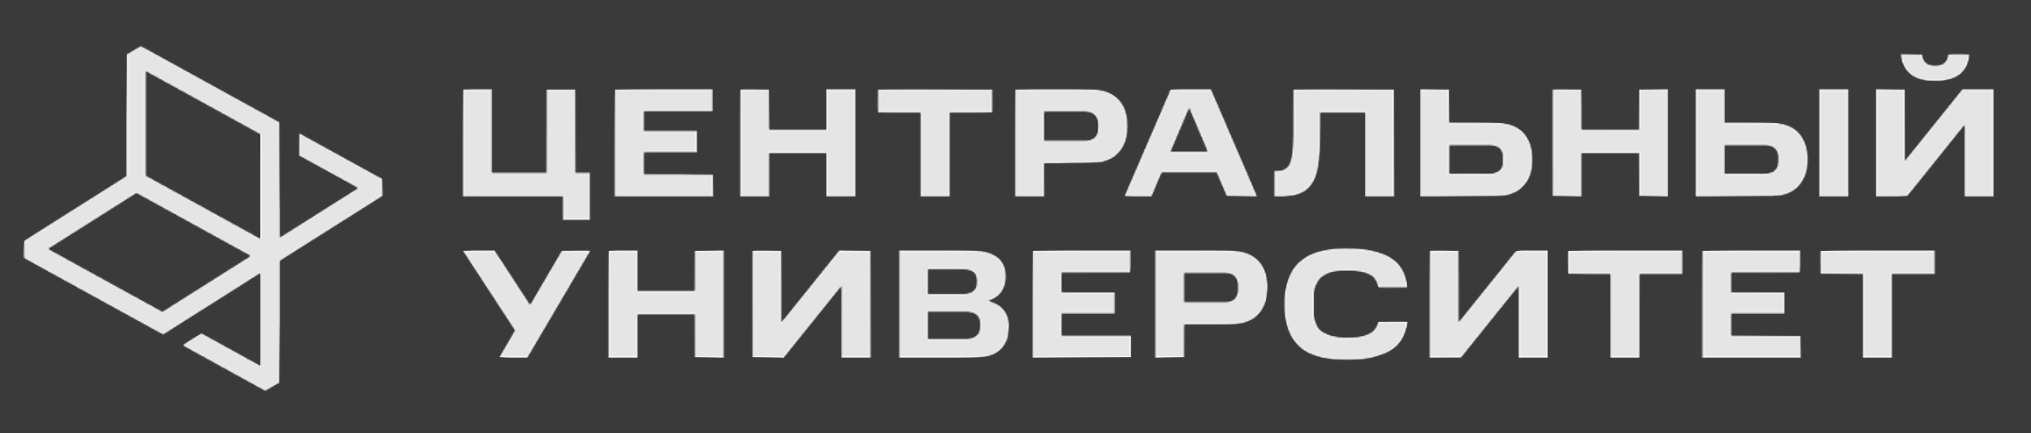

# Курс по Машинному обучению

## Домашнее задание 4. Тренировка поиска оптимальных параметров и обработки данных

### Общие правила

В качестве ответа на это задание вы должны предоставить **Kaggle-ноутбук** (как создать такой ноутбук, читайте ниже), который:
1. генерирует на выходе **csv-файл** по формату `sample_submission.csv` (пример генерации такого формата найдете в конце ноутбука)
2. разрешает чтение пользователю [Ann Lipkina](https://www.kaggle.com/lipann/account).

**Как создать и отправить корректный Kaggle-ноутбук:**

1. На странице соревнования перейдите на вкладку **Code** и нажмите **New Notebook**.
![kaggle_notebook_1.PNG](https://drive.google.com/uc?export=view&id=1Ag0K1plTS5gvQ0XIo7HiOpGQiEXBmhp_)
2. **Никакие дополнительные данные для выполнения задания загружать не нужно** (но это не запрещено). Путь, по которому автоматически находятся необходимые файлы с данными, можно посмотреть, выполнив первую ячейку и изучив ее вывод.
![kaggle_notebook_2](https://drive.google.com/uc?export=view&id=14fva9WSMVqQN5jRQP0KLgaZqx1T-BKRl)

3. Дать права на чтение ноутбука пользователю [Ann Lipkina](https://www.kaggle.com/lipann/account). Для этого в верхней панели ноутбука нужно нажать кнопку **Share**, далее выбрать **Add collaborators** и в поиске найти пользователя Ann Lipkina (вместо owner будет написано collaborator). Не забудьте сохранить изменения кнопкой **Save**.
![kaggle_notebook_3.PNG](https://drive.google.com/uc?export=view&id=1-i7WNFnAqQRRQj49VDwOUQSv1EsPPmct)
![kaggle_notebook_4.PNG](https://drive.google.com/uc?export=view&id=18FaPqnZuuvdwCxZ-T4xDnxiTthXLjvxK)

После правильного действия Вы увидите:

![kaggle_notebook_5.PNG](https://drive.google.com/uc?export=view&id=1Kc0Sq7Paktoo9q_1ZzHgTyKwHE4I3n_G)

4. Для отправки ноутбука в правой его панели выберите вкладку **Submit to competition**, нажмите на кнопку **Submit**, по желанию введите название и описание посылки и подтвердите нажатием кнопки **Submit**.

![kaggle_notebook_6.PNG](https://drive.google.com/uc?export=view&id=1oN9nWMZLXV_dFo0HB1rIxR9t6Me4LiIG)

6. Этот ноутбук доступен в виде публичного кернела во вкладке  `Code` соревнования. Его можно открыть, а затем сразу преобразовать в свой Kaggle-кернел, нажав на три точки справа вверху и выбрав опцию "Copy & edit notebook".
![kaggle_notebook_7.png](https://drive.google.com/uc?export=view&id=1XriF2ZJk4fVhOnisawre9RSJbWVj3LPL)

--------

In [1]:
# Импортируем библиотеки, которые могут вам пригодиться
import os
import nltk
import re
import string

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt

# Можно добавлять и свои библиотеки!

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
PATH_TO_KAGGLE_SUBMISSION = "/kaggle/working/submission.csv" # Сюда можно загрузить решение
# Оно автоматически попадет при submit решения

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-tweets-tonality-prediction/sample_submission.csv
/kaggle/input/covid19-tweets-tonality-prediction/train.csv
/kaggle/input/covid19-tweets-tonality-prediction/test.csv


### Скачаем данные

* [Оригинальный датасет с данными](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/data)
* Классы измнены по схеме

>Extremely Negative, Negative -> Negative

>Neutral -> Neutral

>Extremely Positive, Positive -> Positive

In [3]:
data_train = pd.read_csv("/kaggle/input/covid19-tweets-tonality-prediction/train.csv", encoding='latin-1')
data_test = pd.read_csv("/kaggle/input/covid19-tweets-tonality-prediction/test.csv", encoding='latin-1')

In [4]:
y_train_full = np.array(data_train["Sentiment"])
data_train.drop("Sentiment", axis=1, inplace=True)
data_test.drop("Sentiment", axis=1, inplace=True)

--------

#### Разобьем выборку на 2 части: обучающую, на которой будем делать кросс-валидацию и тестовую, на которой будем сранивать качество между моделям

In [5]:
X_train, X_test_compare, y_train, y_test_compare = train_test_split(
    data_train, y_train_full,
    test_size=0.04,
    stratify=y_train_full
)

#### Сделаем минимальную обработку данных

In [6]:
train_corpus = X_train["OriginalTweet"].tolist() # удобнее работать с таким форматом
test_compare_corpus = X_test_compare["OriginalTweet"].tolist()
test_corpus = data_test["OriginalTweet"].tolist()

vectorizer = TfidfVectorizer(max_features=250, stop_words="english")
vectorizer.fit(train_corpus)

train_corpus_vectorized = vectorizer.transform(train_corpus)
test_compare_corpus_vectorized = vectorizer.transform(test_compare_corpus)
test_corpus = vectorizer.transform(test_corpus)

In [7]:
# Заменим пропуски на новое значение:
X_train.Location = X_train.Location.fillna("Unknown")
X_test_compare.Location = X_test_compare.Location.fillna("Unknown")
data_test.Location = data_test.Location.fillna("Unknown")

In [8]:
X_train_cat = np.array(X_train[["Location", "TweetAt"]])
X_test_compare_cat = np.array(X_test_compare[["Location", "TweetAt"]])
X_test_cat = np.array(data_test[["Location", "TweetAt"]])
# tf-idf, посчитанный выше, подклеим позже

encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="infrequent_if_exist",
    max_categories=250
)
encoder.fit(X_train_cat)

X_train_cat = encoder.transform(X_train_cat)
X_test_compare_cat = encoder.transform(X_test_compare_cat)
X_test_cat = encoder.transform(X_test_cat)


In [9]:
# Подклеиваем посчитанные ранее tf-idf

X_train = np.hstack((X_train_cat, train_corpus_vectorized.toarray())) # Не использовать метод todense!
X_test_compare = np.hstack((X_test_compare_cat, test_compare_corpus_vectorized.toarray()))
X_test = np.hstack((X_test_cat, test_corpus.toarray()))

X_train.shape, X_test_compare.shape, X_test.shape

((39506, 530), (1647, 530), (3798, 530))

----
#### Обучаем модель

Здесь вы должны написать кросс-валидацию с подбором гиперпараметров

In [10]:
clf = KNeighborsClassifier(metric='cosine', n_neighbors=1, weights='uniform')

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

parameters = {
    'n_neighbors': [37 , 41, 45, 49, 53, 57],  
    'metric': ['cosine'],
    'weights': ['uniform']
}

clf_cv = GridSearchCV(estimator=clf, 
                      param_grid=parameters, 
                      cv=StratifiedKFold(n_splits=3), 
                      scoring=LogLoss,
                      verbose=3)

clf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END metric=cosine, n_neighbors=37, weights=uniform;, score=-0.979 total time=  12.6s
[CV 2/3] END metric=cosine, n_neighbors=37, weights=uniform;, score=-0.986 total time=  12.7s
[CV 3/3] END metric=cosine, n_neighbors=37, weights=uniform;, score=-0.985 total time=  12.1s
[CV 1/3] END metric=cosine, n_neighbors=41, weights=uniform;, score=-0.979 total time=  12.5s
[CV 2/3] END metric=cosine, n_neighbors=41, weights=uniform;, score=-0.983 total time=  12.5s
[CV 3/3] END metric=cosine, n_neighbors=41, weights=uniform;, score=-0.981 total time=  12.2s
[CV 1/3] END metric=cosine, n_neighbors=45, weights=uniform;, score=-0.976 total time=  12.4s
[CV 2/3] END metric=cosine, n_neighbors=45, weights=uniform;, score=-0.980 total time=  11.8s
[CV 3/3] END metric=cosine, n_neighbors=45, weights=uniform;, score=-0.980 total time=  12.0s
[CV 1/3] END metric=cosine, n_neighbors=49, weights=uniform;, score=-0.975 total time=  12.4s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(metric='cosine', n_neighbors=1),
             param_grid={'metric': ['cosine'],
                         'n_neighbors': [37, 41, 45, 49, 53, 57],
                         'weights': ['uniform']},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=3)

In [11]:
print(clf_cv.best_score_, clf_cv.best_estimator_)

-0.978367103786865 KNeighborsClassifier(metric='cosine', n_neighbors=49)


#### Посмотрим предсказание на тестовом множестве

### В качестве метрики качества используется **[LogLoss в многоклассовом случае](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)** 

In [12]:
best_loss = 2
best_n = 41
for n in tqdm(range(41, 62)):
    clf = KNeighborsClassifier(n_neighbors=n, weights='uniform', metric='cosine')
    clf.fit(X_train, y_train)
    y_pred_сompare = clf.predict_proba(X_test_compare)
    loss = log_loss(y_test_compare, y_pred_сompare)
    if loss < best_loss:
        best_loss = loss
        best_n = n
best_loss, best_n

100%|██████████| 21/21 [00:50<00:00,  2.39s/it]


(0.9530417911454953, 55)

In [13]:
y_cos = []
y_euclid = []
for n in tqdm(range(21, 88, 2)):
    clf_euclid = KNeighborsClassifier(n_neighbors=n, weights='uniform', metric='euclidean')
    clf_euclid.fit(X_train, y_train)
    y_pred_сompare = clf_euclid.predict_proba(X_test_compare)
    y_euclid.append(log_loss(y_test_compare, y_pred_сompare))
    
    clf_cos = KNeighborsClassifier(n_neighbors=n, weights='uniform', metric='cosine')
    clf_cos.fit(X_train, y_train)
    y_pred_сompare = clf_cos.predict_proba(X_test_compare)
    y_cos.append(log_loss(y_test_compare, y_pred_сompare))

100%|██████████| 34/34 [02:07<00:00,  3.74s/it]


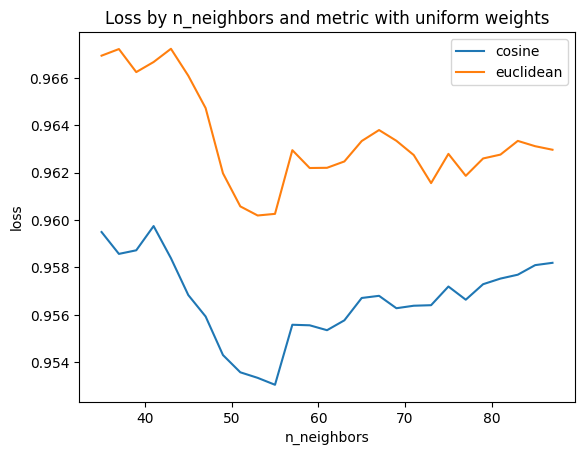

In [14]:
x = list(range(21, 88, 2))
plt.plot(x[7:], y_cos[7:])
plt.plot(x[7:], y_euclid[7:])
plt.title('Loss by n_neighbors and metric with uniform weights')
plt.xlabel('n_neighbors')
plt.legend(['cosine', 'euclidean'])
plt.ylabel('loss');

In [15]:
y_unif = []
y_dist = []
for n in tqdm(range(21, 88, 2)):
    clf_dist = KNeighborsClassifier(n_neighbors=n, weights='distance', metric='cosine')
    clf_dist.fit(X_train, y_train)
    y_pred_сompare = clf_dist.predict_proba(X_test_compare)
    y_dist.append(log_loss(y_test_compare, y_pred_сompare))
    
    clf_unif = KNeighborsClassifier(n_neighbors=n, weights='uniform', metric='cosine')
    clf_unif.fit(X_train, y_train)
    y_pred_сompare = clf_unif.predict_proba(X_test_compare)
    y_unif.append(log_loss(y_test_compare, y_pred_сompare))

100%|██████████| 34/34 [02:44<00:00,  4.83s/it]


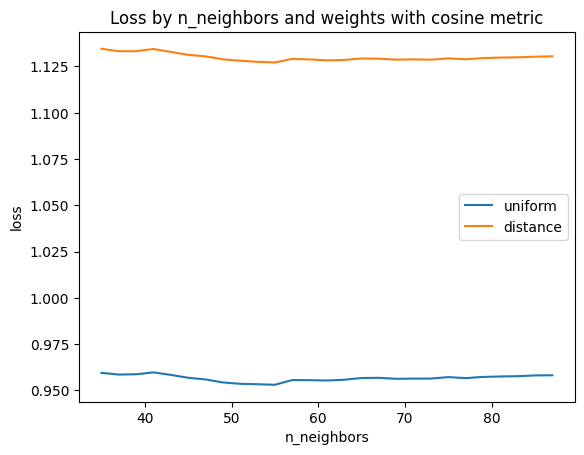

In [16]:
x = list(range(21, 88, 2))
plt.plot(x[7:], y_unif[7:])
plt.plot(x[7:], y_dist[7:])
plt.title('Loss by n_neighbors and weights with cosine metric')
plt.xlabel('n_neighbors')
plt.legend(['uniform', 'distance'])
plt.ylabel('loss');

#### <font color="red">Следите за тем, чтобы predict_proba возвращал вероятности ровно в таком (алфавитном) порядке!</font>

#### ['Negative', 'Neutral', 'Positive']

#### Не шафлите данные в тестовом датасете, важно чтобы выходной порядок совпадал с входным порядком данных



#### Сгенерируем посылку. Пути уже все прописаны, их можно не менять

In [17]:
clf = KNeighborsClassifier(n_neighbors=best_n, weights='uniform', metric='cosine')
clf.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=55)

In [18]:
# Сделаем предсказание на тестовых данных, качество на которых проверяются в посылке (submission)
y_pred = clf.predict_proba(X_test)

In [19]:
dt = pd.DataFrame(y_pred, columns=['Negative', 'Neutral', 'Positive'])
dt["id"] = range(len(y_pred))
dt

,Negative,Neutral,Positive,id
0,0.400000,0.254545,0.345455,0
1,0.345455,0.163636,0.490909,1
2,0.272727,0.018182,0.709091,2
3,0.672727,0.145455,0.181818,3
4,0.381818,0.181818,0.436364,4
...,...,...,...,...
3793,0.418182,0.163636,0.418182,3793
3794,0.509091,0.181818,0.309091,3794
3795,0.345455,0.327273,0.327273,3795
3796,0.363636,0.127273,0.509091,3796


In [20]:
PATH_TO_KAGGLE_SUBMISSION = "/kaggle/working/submission.csv"
dt.to_csv(PATH_TO_KAGGLE_SUBMISSION, index=False)